In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 50

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 324447775.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4203181.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 145530310.10it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20729628.69it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
sample = next(iter(data))
print(sample[0].shape, sample[1].shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [ ]:
def show_image(x, idx):
    x = x.view(-1, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

Class - 6


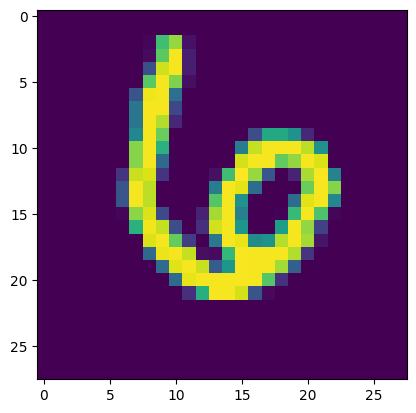

In [ ]:
show_image(sample[0], idx=0)
print(f"Class - {sample[1][0]}")

### Автоэнкодер

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch - {epoch}")
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)
autoencoder = train(autoencoder, data)

Epoch - 0
Epoch - 1
Epoch - 2
Epoch - 3
Epoch - 4
Epoch - 5
Epoch - 6
Epoch - 7
Epoch - 8
Epoch - 9
Epoch - 10
Epoch - 11
Epoch - 12
Epoch - 13
Epoch - 14
Epoch - 15
Epoch - 16
Epoch - 17
Epoch - 18
Epoch - 19


In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

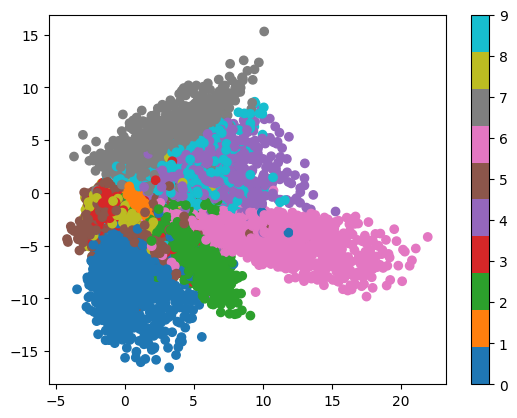

In [ ]:
plot_latent(autoencoder, data)

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

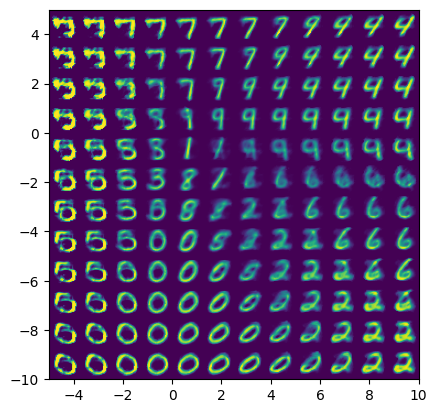

In [ ]:
plot_reconstructed(autoencoder)

### Вариационный автоэнкодер

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch - {epoch}")
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, data)

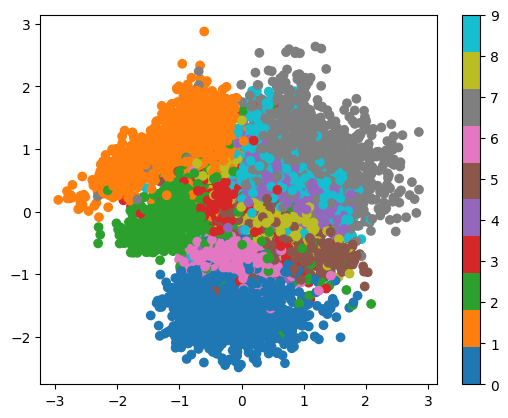

In [ ]:
plot_latent(vae, data)

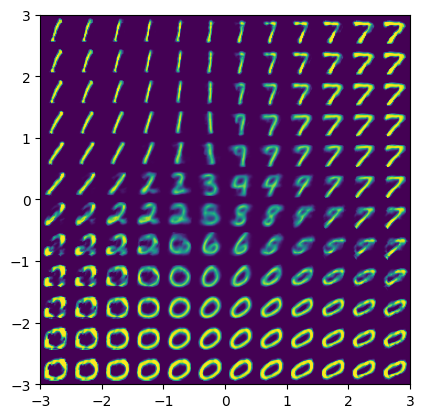

In [ ]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][0].to(device)
x_0 = x[y == 0][0].to(device)

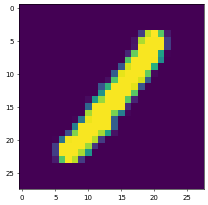

In [ ]:
show_image(x_1, idx=0)

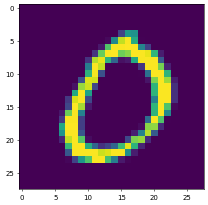

In [ ]:
show_image(x_0, idx=0)

In [ ]:
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

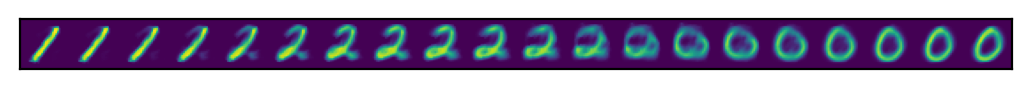

In [ ]:
interpolate(vae, x_1, x_0, n=20)

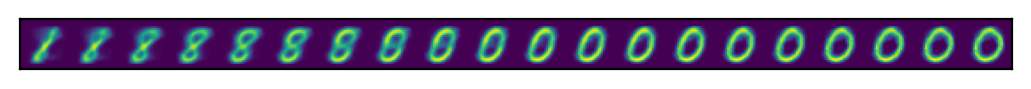

In [ ]:
interpolate(autoencoder, x_1, x_0, n=20)

In [ ]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1]

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [ ]:
interpolate_gif(vae, "vae", x_1, x_0)

### Вариационный энкодер с условием

In [ ]:
class CVariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(CVariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784 + 10, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x, label):
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((x, label), dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class CVariationalDecoder(nn.Module):
    def __init__(self, latent_dims):
        super(CVariationalDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims + 10, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z, label):
        z = F.relu(self.linear1(torch.cat((z, label), dim=1)))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class CVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(CVariationalAutoencoder, self).__init__()
        self.encoder = CVariationalEncoder(latent_dims)
        self.decoder = CVariationalDecoder(latent_dims)

    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z, y)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch - {epoch}")
        for x, y in data:
            x = x.to(device)
            y = torch.nn.functional.one_hot(y, num_classes=10).to(device)
            opt.zero_grad()
            x_hat = autoencoder(x, y)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
cvae = CVariationalAutoencoder(latent_dims).to(device)
cvae = train(cvae, data)

In [ ]:
def plot_latent_cvae(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device),
          torch.nn.functional.one_hot(y, num_classes=10).to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

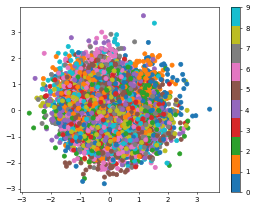

In [ ]:
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 50
plot_latent_cvae(cvae, data)

In [ ]:
def plot_reconstructed_cvae(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12,
                            label=torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z, label.to(device))
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

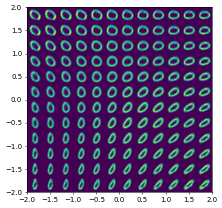

In [ ]:
plot_reconstructed_cvae(cvae, r0=(-2, 2), r1=(-2, 2),
  label=torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

### Доп. материалы

**Вопрос:**

MSE или BCE в функции потерь?

- https://www.expunctis.com/2019/01/27/Loss-functions.html
- https://ai.stackexchange.com/questions/27341/in-variational-autoencoders-why-do-people-use-mse-for-the-loss
- https://arxiv.org/pdf/1312.6114.pdf#page=10
- https://github.com/pytorch/examples/issues/399

**Ссылки:**

[DeepMind x UCL | Deep Learning Lectures | 11/12 | Modern Latent Variable Models](https://www.youtube.com/watch?v=7Pcvdo4EJeo)

**Домашнее задание:**
Трансфер стиля (например - https://arxiv.org/pdf/2110.07375.pdf)
Запустите обучение на GPU/TPU c pytorch_xla и предоставьте сравнение (по времени) pytorch[gpu] / pytorch_xla[gpu] / pytorch_xla[tpu].




In [3]:
# @title Config

# Один из: "torch_gpu", "xla_gpu", "xla_tpu"
BACKEND = "torch_gpu"  #@param ["torch_gpu", "xla_gpu", "xla_tpu"]

IMAGE_SIZE = 128        #@param {type:"integer"}
LATENT_DIM = 128        #@param {type:"integer"}
BATCH_SIZE = 32         #@param {type:"integer"}
EPOCHS = 5              #@param {type:"integer"}
LR = 2e-4               #@param {type:"number"}
BETA_KL = 0.1           # вес KL в VAE-лоссе

print("Backend:", BACKEND)


Backend: torch_gpu


In [4]:
!pip install torch_xla

In [5]:
# @title Install torch_xla if needed
import os, subprocess, sys

if BACKEND == "xla_tpu":
    # Ожидаем, что в Colab выбран runtime с TPU (Runtime → Change runtime type → TPU)
    # Колёсико для Colab TPU (версия может меняться — см. README PyTorch/XLA)
    # Пример для torch 2.0 + XLA 2.0:
    cmd = [
        sys.executable, "-m", "pip", "install",
        "cloud-tpu-client==0.10",
        "torch==2.0.0",
        "torchvision==0.15.1",
        "https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl",
        "-q"
    ]
    print("Installing torch_xla for TPU...")
    subprocess.run(cmd, check=True)
    print("Done.")

elif BACKEND == "xla_gpu":
    # XLA:GPU лучше запускать в VM/докере, но условный вариант:
    # pip install torch_xla (CPU) + отдельное GPU-wheel при необходимости.:contentReference[oaicite:1]{index=1}
    print("Installing torch_xla (you may need a GPU-specific wheel in real env)...")
    cmd = [sys.executable, "-m", "pip", "install", "torch_xla", "-q"]
    subprocess.run(cmd, check=True)
    print("Done.")
else:
    print("torch_xla is not required for BACKEND =", BACKEND)


torch_xla is not required for BACKEND = torch_gpu


In [6]:
# @title Imports and device selection

import os
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image

device = None
xm = None   # будет модулем torch_xla.core.xla_model при XLA backend’ах

if BACKEND == "torch_gpu":
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print("Using device:", device)

elif BACKEND in ("xla_gpu", "xla_tpu"):
    # Важно: PJRT_DEVICE должен быть выставлен до инициализации runtime XLA:contentReference[oaicite:2]{index=2}
    if BACKEND == "xla_tpu":
        os.environ["PJRT_DEVICE"] = "TPU"
    else:
        os.environ["PJRT_DEVICE"] = "CUDA"

    import torch_xla
    import torch_xla.core.xla_model as xm

    device = xm.xla_device()
    print("Using XLA device:", device)
else:
    raise ValueError("Unknown BACKEND")


Using device: cuda


In [7]:
# @title Download selfie2anime & face2anime from Google Drive

import os, shutil
from pathlib import Path

# Если переменные не определены (на всякий случай) — задаём дефолты
try:
    SELFIE2ANIME_ROOT
except NameError:
    SELFIE2ANIME_ROOT = "/content/selfie2anime"

try:
    FACE2ANIME_REAL_DIR
    FACE2ANIME_ANIME_DIR
except NameError:
    FACE2ANIME_REAL_DIR = "/content/face2anime/photo"
    FACE2ANIME_ANIME_DIR = "/content/face2anime/anime"

print("SELFIE2ANIME_ROOT:", SELFIE2ANIME_ROOT)
print("FACE2ANIME_REAL_DIR:", FACE2ANIME_REAL_DIR)
print("FACE2ANIME_ANIME_DIR:", FACE2ANIME_ANIME_DIR)

!pip install -q gdown

# ============================================================
# 1. selfie2anime с Google Drive
#    https://drive.google.com/file/d/1xOWj1UVgp6NKMT3HbPhBbtq2A4EDkghF/view
# ============================================================

s2a_id = "1xOWj1UVgp6NKMT3HbPhBbtq2A4EDkghF"
s2a_zip = "/content/selfie2anime.zip"

if not Path(s2a_zip).exists():
    print("Downloading selfie2anime from Google Drive...")
    !gdown --id "$s2a_id" -O "$s2a_zip"

tmp_s2a = Path("/content/selfie2anime_tmp")
if tmp_s2a.exists():
    shutil.rmtree(tmp_s2a)
tmp_s2a.mkdir(parents=True, exist_ok=True)

print("Unzipping selfie2anime...")
!unzip -q "$s2a_zip" -d "/content/selfie2anime_tmp"

# Ищем папку с trainA/trainB (часто это что-то вроде selfie2anime/ или datasets/selfie2anime/)
candidate = tmp_s2a
subdirs = [p for p in tmp_s2a.iterdir() if p.is_dir()]
for d in subdirs:
    if (d / "trainA").exists() and (d / "trainB").exists():
        candidate = d
        break

os.makedirs(SELFIE2ANIME_ROOT, exist_ok=True)

# очищаем старое содержимое
for name in ("trainA", "trainB", "testA", "testB"):
    dst = Path(SELFIE2ANIME_ROOT) / name
    if dst.exists():
        shutil.rmtree(dst)

# переносим папки
for name in ("trainA", "trainB", "testA", "testB"):
    src = candidate / name
    if src.exists():
        dst = Path(SELFIE2ANIME_ROOT) / name
        shutil.move(str(src), str(dst))

print("✅ selfie2anime downloaded.")
print("Contents of SELFIE2ANIME_ROOT:", os.listdir(SELFIE2ANIME_ROOT))

# ============================================================
# 2. face2anime с Google Drive
#    https://drive.google.com/file/d/1Exc6QumR2r0aFUtfHOdAgle4F4I9zwF3/view
# Структура архива:
# /face2anime_tmp/face2anime/
#   train/trainA, train/trainB
#   test/testA,  test/testB
# A = real (photo), B = anime
# ============================================================

f2a_id = "1Exc6QumR2r0aFUtfHOdAgle4F4I9zwF3"
f2a_zip = "/content/face2anime.zip"

if not Path(f2a_zip).exists():
    print("Downloading face2anime from Google Drive...")
    !gdown --id "$f2a_id" -O "$f2a_zip"

tmp_f2a = Path("/content/face2anime_tmp")
if tmp_f2a.exists():
    shutil.rmtree(tmp_f2a)
tmp_f2a.mkdir(parents=True, exist_ok=True)

print("Unzipping face2anime...")
!unzip -q "$f2a_zip" -d "/content/face2anime_tmp"

root_f2a = tmp_f2a / "face2anime"
assert root_f2a.exists(), f"Ожидалась папка {root_f2a}, проверь структуру face2anime.zip."

# очищаем и пересоздаём целевые директории
for d in [FACE2ANIME_REAL_DIR, FACE2ANIME_ANIME_DIR]:
    d_path = Path(d)
    if d_path.exists():
        shutil.rmtree(d_path)
    d_path.mkdir(parents=True, exist_ok=True)

# Переносим:
#   trainA + testA -> FACE2ANIME_REAL_DIR
#   trainB + testB -> FACE2ANIME_ANIME_DIR
for split in ["train", "test"]:
    split_dir = root_f2a / split
    if not split_dir.exists():
        continue

    for domain, dst_dir in [("A", FACE2ANIME_REAL_DIR),
                            ("B", FACE2ANIME_ANIME_DIR)]:
        src = split_dir / f"{split}{domain}"   # train/trainA, train/trainB, test/testA, test/testB
        if not src.exists():
            continue

        files = list(src.glob("*"))
        for p in files:
            if p.is_file():
                shutil.move(str(p), dst_dir)

print("✅ face2anime downloaded & organized.")
print("Real images in FACE2ANIME_REAL_DIR:", len(os.listdir(FACE2ANIME_REAL_DIR)))
print("Anime images in FACE2ANIME_ANIME_DIR:", len(os.listdir(FACE2ANIME_ANIME_DIR)))


SELFIE2ANIME_ROOT: /content/selfie2anime
FACE2ANIME_REAL_DIR: /content/face2anime/photo
FACE2ANIME_ANIME_DIR: /content/face2anime/anime
Unzipping selfie2anime...
✅ selfie2anime downloaded.
Contents of SELFIE2ANIME_ROOT: ['trainB', 'testB', 'trainA', 'testA']
Unzipping face2anime...
✅ face2anime downloaded & organized.
Real images in FACE2ANIME_REAL_DIR: 7898
Anime images in FACE2ANIME_ANIME_DIR: 7898


In [8]:
# @title Dataset paths and transforms

# TODO: поменяй на свои реальные пути в Colab (например, /content/drive/MyDrive/...)
SELFIE2ANIME_ROOT = "/content/selfie2anime"  # с подкаталогами trainA, trainB
FACE2ANIME_REAL_DIR = "/content/face2anime/photo"   # реальные лица
FACE2ANIME_ANIME_DIR = "/content/face2anime/anime"  # аниме лица

print("Selfie2Anime root:", SELFIE2ANIME_ROOT)
print("Face2Anime real dir:", FACE2ANIME_REAL_DIR)
print("Face2Anime anime dir:", FACE2ANIME_ANIME_DIR)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])


Selfie2Anime root: /content/selfie2anime
Face2Anime real dir: /content/face2anime/photo
Face2Anime anime dir: /content/face2anime/anime


In [9]:
# @title Build PyTorch datasets (flat folders, no class subdirs)

from torch.utils.data import Dataset, ConcatDataset
from torchvision import datasets
from PIL import Image
from pathlib import Path
import os

class FlatImageDataset(Dataset):
    """
    Загружает все картинки из указанной папки (без подпапок-классов).
    Метка всегда 0, т.к. нам она не нужна.
    """
    def __init__(self, root, transform=None,
                 exts=(".jpg", ".jpeg", ".png", ".bmp", ".webp")):
        self.root = Path(root)
        self.transform = transform
        self.exts = tuple(e.lower() for e in exts)

        self.files = []
        for p in self.root.rglob("*"):
            if p.is_file() and p.suffix.lower() in self.exts:
                self.files.append(p)

        if len(self.files) == 0:
            print(f"[WARN] No image files found in {self.root}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = 0  # фиктивная метка
        return img, label


def make_flat_dataset_if_exists(path: str, transform):
    path = Path(path)
    if not path.exists():
        print(f"[WARN] path not found, skipping: {path}")
        return None
    ds = FlatImageDataset(path, transform=transform)
    print(f"Loaded {len(ds)} images from {path}")
    return ds


real_datasets = []
anime_datasets = []

# Selfie2Anime: trainA = real, trainB = anime
s2a_trainA = make_flat_dataset_if_exists(os.path.join(SELFIE2ANIME_ROOT, "trainA"), transform)
s2a_trainB = make_flat_dataset_if_exists(os.path.join(SELFIE2ANIME_ROOT, "trainB"), transform)
if s2a_trainA is not None:
    real_datasets.append(s2a_trainA)
if s2a_trainB is not None:
    anime_datasets.append(s2a_trainB)

# Face2Anime: мы раньше разложили всё так, что
# FACE2ANIME_REAL_DIR = папка с real-фотками (плоская)
# FACE2ANIME_ANIME_DIR = папка с anime (плоская)
f2a_real = make_flat_dataset_if_exists(FACE2ANIME_REAL_DIR, transform)
f2a_anime = make_flat_dataset_if_exists(FACE2ANIME_ANIME_DIR, transform)
if f2a_real is not None:
    real_datasets.append(f2a_real)
if f2a_anime is not None:
    anime_datasets.append(f2a_anime)

assert len(real_datasets) > 0, "No real-face datasets found, check paths."
assert len(anime_datasets) > 0, "No anime-face datasets found, check paths."

real_dataset = ConcatDataset(real_datasets)
anime_dataset = ConcatDataset(anime_datasets)

print("Total real images:", len(real_dataset))
print("Total anime images:", len(anime_dataset))

real_loader = DataLoader(real_dataset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=2, drop_last=True)
anime_loader = DataLoader(anime_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, drop_last=True)


Loaded 3400 images from /content/selfie2anime/trainA
Loaded 3400 images from /content/selfie2anime/trainB
Loaded 7898 images from /content/face2anime/photo
Loaded 7898 images from /content/face2anime/anime
Total real images: 11298
Total anime images: 11298


In [10]:
# @title VAE model definition

class Encoder(nn.Module):
    def __init__(self, latent_dim=128, img_channels=3):
        super().__init__()
        ch = 64
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, ch, 4, 2, 1),  # 64x64
            nn.ReLU(inplace=True),
            nn.Conv2d(ch, ch*2, 4, 2, 1),         # 32x32
            nn.BatchNorm2d(ch*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch*2, ch*4, 4, 2, 1),       # 16x16
            nn.BatchNorm2d(ch*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch*4, ch*8, 4, 2, 1),       # 8x8
            nn.BatchNorm2d(ch*8),
            nn.ReLU(inplace=True),
        )
        self.feature_size = ch*8 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16)
        self.fc_mu = nn.Linear(self.feature_size, latent_dim)
        self.fc_logvar = nn.Linear(self.feature_size, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim=128, img_channels=3):
        super().__init__()
        ch = 64
        self.fc = nn.Linear(latent_dim, ch*8 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16))
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(ch*8, ch*4, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(ch*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ch*4, ch*2, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(ch*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ch*2, ch, 4, 2, 1),    # 64x64
            nn.BatchNorm2d(ch),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ch, img_channels, 4, 2, 1),  # 128x128
            nn.Tanh()
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(z.size(0), -1, IMAGE_SIZE // 16, IMAGE_SIZE // 16)
        x_rec = self.deconv(h)
        return x_rec


class StyleVAE(nn.Module):
    """
    Общий encoder + два decoder'а для разных доменов (real/anime).
    """
    def __init__(self, latent_dim=128, img_channels=3):
        super().__init__()
        self.encoder = Encoder(latent_dim, img_channels)
        self.decoder_real = Decoder(latent_dim, img_channels)
        self.decoder_anime = Decoder(latent_dim, img_channels)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar

    def decode(self, z, domain: str):
        if domain == "real":
            return self.decoder_real(z)
        elif domain == "anime":
            return self.decoder_anime(z)
        else:
            raise ValueError("domain must be 'real' or 'anime'")

    def forward(self, x, domain: str):
        z, mu, logvar = self.encode(x)
        recon = self.decode(z, domain)
        return recon, mu, logvar, z


In [11]:
# @title Loss function and utils

def vae_loss(recon_x, x, mu, logvar, beta_kl=1.0):
    # Reconstruction: L1
    recon_loss = F.l1_loss(recon_x, x, reduction="mean")
    # KL(q(z|x) || N(0, I))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta_kl * kl, recon_loss, kl

def to_image_range(x):
    # из [-1, 1] -> [0, 1]
    return (x.clamp(-1, 1) + 1) / 2.0


In [12]:
# @title Init model and optimizer

model = StyleVAE(latent_dim=LATENT_DIM, img_channels=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.5, 0.999))

print("Number of parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")


Number of parameters: 25.115206 M


In [13]:
# @title Training loop

def train_style_vae(model, real_loader, anime_loader, epochs, backend, beta_kl=1.0):
    model.train()
    history = []
    global xm  # из предыдущей ячейки (None для обычного torch)

    for epoch in range(1, epochs + 1):
        epoch_start = time.perf_counter()
        total_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        num_batches = 0

        # zip гарантирует одинаковое количество шагов по обоим доменам
        for (real_imgs, _), (anime_imgs, _) in zip(real_loader, anime_loader):
            num_batches += 1

            real_imgs = real_imgs.to(device)
            anime_imgs = anime_imgs.to(device)

            optimizer.zero_grad()

            # --- real domain ---
            real_recon, real_mu, real_logvar, real_z = model(real_imgs, domain="real")
            loss_real, rec_real, kl_real = vae_loss(real_recon, real_imgs, real_mu, real_logvar, beta_kl=beta_kl)

            # --- anime domain ---
            anime_recon, anime_mu, anime_logvar, anime_z = model(anime_imgs, domain="anime")
            loss_anime, rec_anime, kl_anime = vae_loss(anime_recon, anime_imgs, anime_mu, anime_logvar, beta_kl=beta_kl)

            # Можно добавить перекрёстный стиль (опционально):
            # stylized = model.decode(real_z.detach(), domain="anime")
            # cycle_recon, _, _ = ... (доп. лоссы)

            loss = loss_real + loss_anime

            if backend.startswith("xla") and xm is not None:
                loss.backward()
                xm.optimizer_step(optimizer, barrier=True)
                xm.mark_step()
            else:
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            total_recon += (rec_real.item() + rec_anime.item()) / 2.0
            total_kl += (kl_real.item() + kl_anime.item()) / 2.0

        epoch_time = time.perf_counter() - epoch_start
        avg_loss = total_loss / num_batches
        avg_recon = total_recon / num_batches
        avg_kl = total_kl / num_batches

        history.append({
            "epoch": epoch,
            "time_sec": epoch_time,
            "loss": avg_loss,
            "recon": avg_recon,
            "kl": avg_kl,
        })

        print(f"[{backend}] Epoch {epoch}/{epochs} | "
              f"time={epoch_time:.2f}s | loss={avg_loss:.4f} | "
              f"recon={avg_recon:.4f} | kl={avg_kl:.4f}")

    return history


In [14]:
# @title Run training

history = train_style_vae(
    model=model,
    real_loader=real_loader,
    anime_loader=anime_loader,
    epochs=EPOCHS,
    backend=BACKEND,
    beta_kl=BETA_KL,
)

# Сохраняем, чтобы можно было скачать и сравнить из разных запусков
import json

out_file = f"/content/history_{BACKEND}.json"
with open(out_file, "w") as f:
    json.dump(history, f, indent=2)

print("Saved history to", out_file)
history


[torch_gpu] Epoch 1/5 | time=61.62s | loss=0.7079 | recon=0.3188 | kl=0.3511
[torch_gpu] Epoch 2/5 | time=63.23s | loss=0.5621 | recon=0.2482 | kl=0.3292
[torch_gpu] Epoch 3/5 | time=62.17s | loss=0.5290 | recon=0.2312 | kl=0.3335
[torch_gpu] Epoch 4/5 | time=61.94s | loss=0.5113 | recon=0.2218 | kl=0.3378
[torch_gpu] Epoch 5/5 | time=60.95s | loss=0.5002 | recon=0.2158 | kl=0.3433
Saved history to /content/history_torch_gpu.json


[{'epoch': 1,
  'time_sec': 61.61561782799993,
  'loss': 0.7078668061464434,
  'recon': 0.318827719657178,
  'kl': 0.3510568278496056},
 {'epoch': 2,
  'time_sec': 63.226638621000006,
  'loss': 0.5621329341664193,
  'recon': 0.2481505673473685,
  'kl': 0.32915900236064244},
 {'epoch': 3,
  'time_sec': 62.16933011600008,
  'loss': 0.5290082714206437,
  'recon': 0.2311583952846338,
  'kl': 0.3334573977771967},
 {'epoch': 4,
  'time_sec': 61.93708704699998,
  'loss': 0.5112534110505588,
  'recon': 0.22184310988562642,
  'kl': 0.33783595451805476},
 {'epoch': 5,
  'time_sec': 60.94985590199997,
  'loss': 0.5002073186315152,
  'recon': 0.21577729092694545,
  'kl': 0.34326367481234393}]

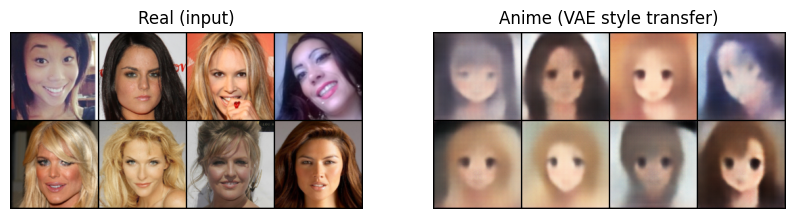

In [20]:
# @title Stylize some real faces and visualize

import matplotlib.pyplot as plt
def test():
  model.eval()
  real_batch, _ = next(iter(real_loader))
  real_batch = real_batch.to(device)

  with torch.no_grad():
      z, _ = model.encoder(real_batch)
      anime_fake = model.decode(z, domain="anime")

  real_vis = to_image_range(real_batch.cpu())
  anime_vis = to_image_range(anime_fake.cpu())

  grid_real = make_grid(real_vis[:8], nrow=4)
  grid_anime = make_grid(anime_vis[:8], nrow=4)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Real (input)")
  plt.axis("off")
  plt.imshow(grid_real.permute(1, 2, 0).numpy())

  plt.subplot(1, 2, 2)
  plt.title("Anime (VAE style transfer)")
  plt.axis("off")
  plt.imshow(grid_anime.permute(1, 2, 0).numpy())
  plt.show()
test()


In [14]:
import matplotlib.pyplot as plt
def test():
  model.eval()
  real_batch, _ = next(iter(real_loader))
  real_batch = real_batch.to(device)

  with torch.no_grad():
      z, _ = model.encoder(real_batch)
      anime_fake = model.decode(z, domain="anime")

  real_vis = to_image_range(real_batch.cpu())
  anime_vis = to_image_range(anime_fake.cpu())

  grid_real = make_grid(real_vis[:8], nrow=4)
  grid_anime = make_grid(anime_vis[:8], nrow=4)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Real (input)")
  plt.axis("off")
  plt.imshow(grid_real.permute(1, 2, 0).numpy())

  plt.subplot(1, 2, 2)
  plt.title("Anime (VAE style transfer)")
  plt.axis("off")
  plt.imshow(grid_anime.permute(1, 2, 0).numpy())
  plt.show()

# Сравнение pytorch и XLA_TPU

XLA_GPU не работает в коллабе.

In [15]:
BACKEND = "torch_gpu"  #@param ["torch_gpu", "xla_gpu", "xla_tpu"]
EPOCHS = 10
model = StyleVAE(latent_dim=LATENT_DIM, img_channels=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.5, 0.999))

print("Number of parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")

history = train_style_vae(
    model=model,
    real_loader=real_loader,
    anime_loader=anime_loader,
    epochs=EPOCHS,
    backend=BACKEND,
    beta_kl=BETA_KL,
)

# Сохраняем, чтобы можно было скачать и сравнить из разных запусков
import json

out_file = f"/content/history_{BACKEND}.json"
with open(out_file, "w") as f:
    json.dump(history, f, indent=2)

print("Saved history to", out_file)
history

Number of parameters: 25.115206 M
[torch_gpu] Epoch 1/10 | time=73.09s | loss=0.7102 | recon=0.3199 | kl=0.3519
[torch_gpu] Epoch 2/10 | time=65.75s | loss=0.5623 | recon=0.2474 | kl=0.3377
[torch_gpu] Epoch 3/10 | time=64.16s | loss=0.5319 | recon=0.2317 | kl=0.3425
[torch_gpu] Epoch 4/10 | time=64.35s | loss=0.5118 | recon=0.2216 | kl=0.3430
[torch_gpu] Epoch 5/10 | time=64.06s | loss=0.5009 | recon=0.2157 | kl=0.3476
[torch_gpu] Epoch 6/10 | time=63.56s | loss=0.4925 | recon=0.2111 | kl=0.3513
[torch_gpu] Epoch 7/10 | time=64.17s | loss=0.4890 | recon=0.2085 | kl=0.3603
[torch_gpu] Epoch 8/10 | time=64.27s | loss=0.4811 | recon=0.2041 | kl=0.3646
[torch_gpu] Epoch 9/10 | time=64.31s | loss=0.4782 | recon=0.2023 | kl=0.3681
[torch_gpu] Epoch 10/10 | time=65.83s | loss=0.4751 | recon=0.2004 | kl=0.3714
Saved history to /content/history_torch_gpu.json


[{'epoch': 1,
  'time_sec': 73.09404247600003,
  'loss': 0.7101658641785468,
  'recon': 0.3198906949407318,
  'kl': 0.3519223816059635},
 {'epoch': 2,
  'time_sec': 65.74686877699997,
  'loss': 0.5623252645092713,
  'recon': 0.24738777042617202,
  'kl': 0.33774861836906195},
 {'epoch': 3,
  'time_sec': 64.15582353300005,
  'loss': 0.5319461581051856,
  'recon': 0.23172308808514483,
  'kl': 0.34249990361692545},
 {'epoch': 4,
  'time_sec': 64.34857864700007,
  'loss': 0.5118493355873962,
  'recon': 0.22162920031854857,
  'kl': 0.3429546612855733},
 {'epoch': 5,
  'time_sec': 64.05643140899997,
  'loss': 0.5008628198681743,
  'recon': 0.21567591469703248,
  'kl': 0.3475549497111323},
 {'epoch': 6,
  'time_sec': 63.562296272000026,
  'loss': 0.4925240935921331,
  'recon': 0.21113696078065436,
  'kl': 0.3512508569881531},
 {'epoch': 7,
  'time_sec': 64.16836683399993,
  'loss': 0.4890006681846154,
  'recon': 0.2084707904807569,
  'kl': 0.3602954275040721},
 {'epoch': 8,
  'time_sec': 64.26

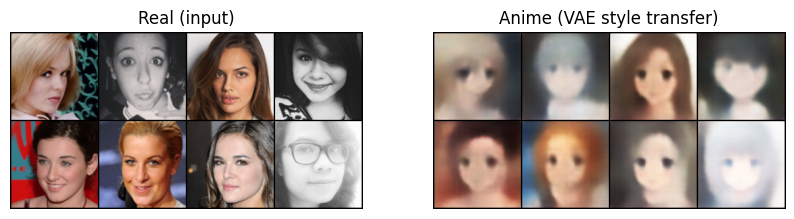

In [17]:
test()


In [12]:
BACKEND = "xla_tpu"  #@param ["torch_gpu", "xla_gpu", "xla_tpu"]
import torch_xla
import torch_xla.core.xla_model as xm

device = xm.xla_device()
print("Using XLA device:", device)
# @title Run training
model = StyleVAE(latent_dim=LATENT_DIM, img_channels=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.5, 0.999))
EPOCHS = 10
print("Number of parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")

history = train_style_vae(
    model=model,
    real_loader=real_loader,
    anime_loader=anime_loader,
    epochs=EPOCHS,
    backend=BACKEND,
    beta_kl=BETA_KL,
)

# Сохраняем, чтобы можно было скачать и сравнить из разных запусков
import json

out_file = f"/content/history_{BACKEND}.json"
with open(out_file, "w") as f:
    json.dump(history, f, indent=2)

print("Saved history to", out_file)
history

/usr/local/lib/python3.12/dist-packages/torch_xla/__init__.py:246: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


KeyboardInterrupt: 

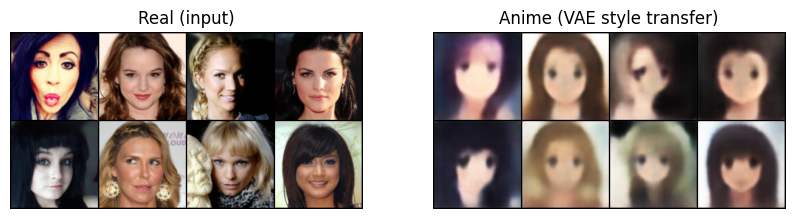

In [19]:
test()

Выберите 2 JSON-файла с history (torch_gpu и xla_tpu).


Saving history_torch_gpu (1).json to history_torch_gpu (1).json
Saving history_xla_tpu.json to history_xla_tpu.json


,epoch,time_sec,loss,recon,kl,backend
0,1,73.094042,0.710166,0.319891,0.351922,torch_gpu
1,2,65.746869,0.562325,0.247388,0.337749,torch_gpu
2,3,64.155824,0.531946,0.231723,0.342500,torch_gpu
3,4,64.348579,0.511849,0.221629,0.342955,torch_gpu
4,5,64.056431,0.500863,0.215676,0.347555,torch_gpu


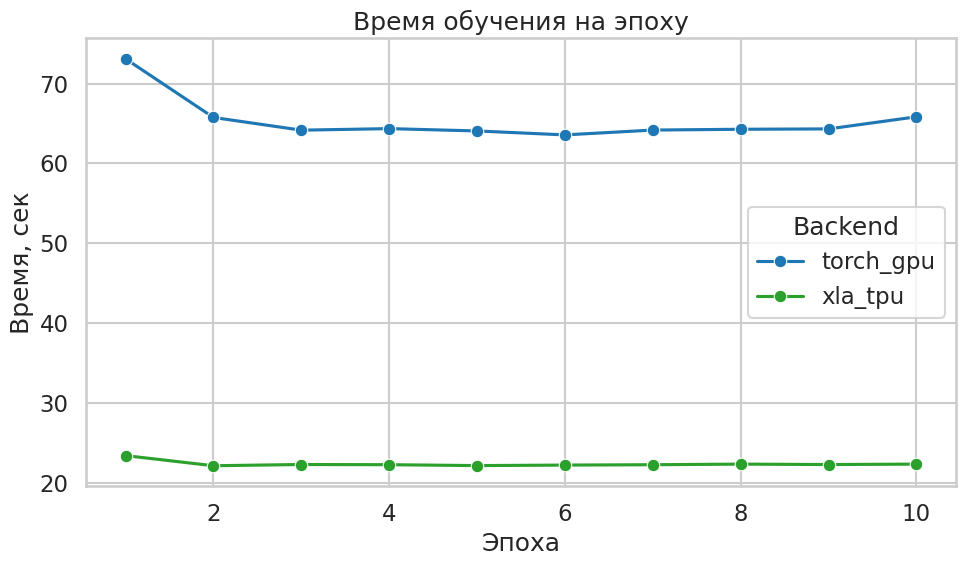

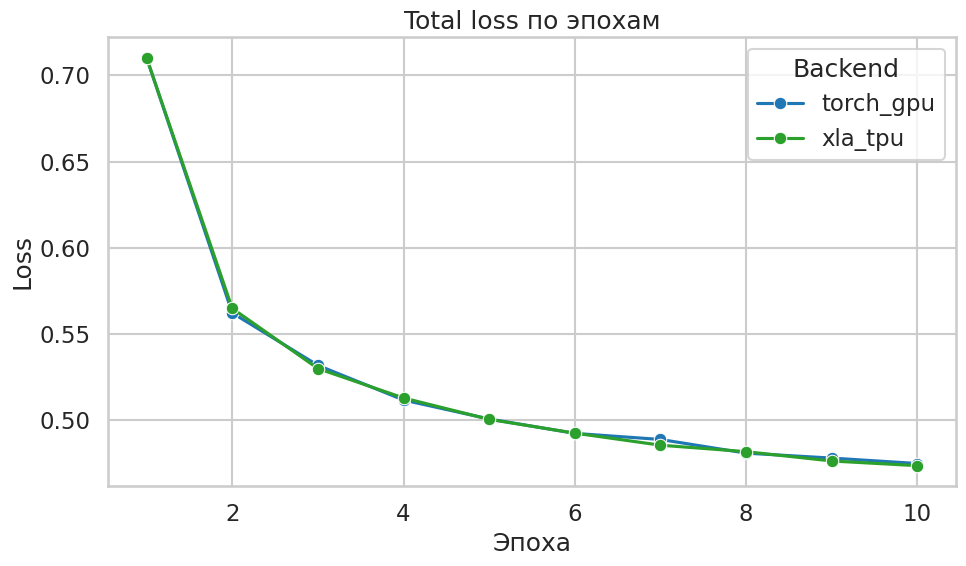

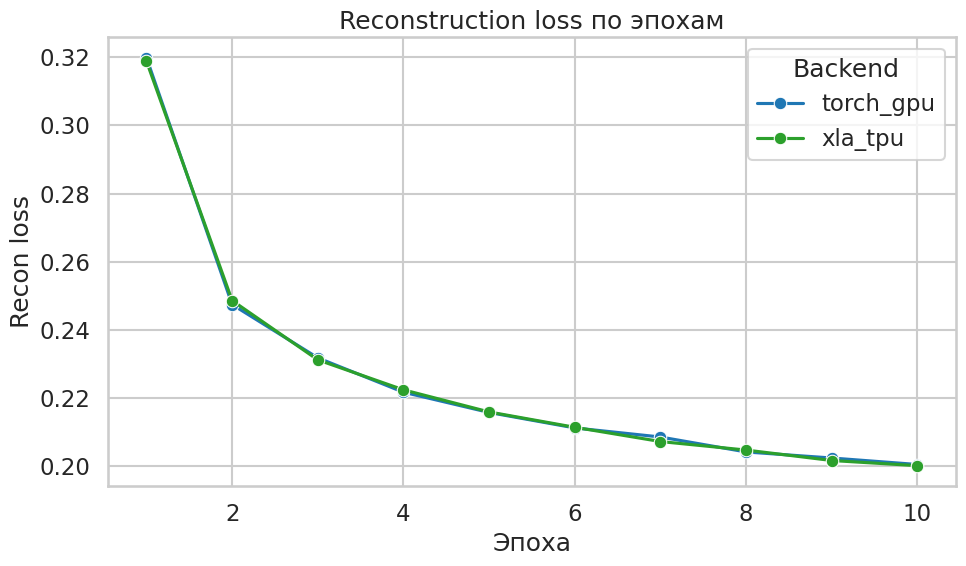

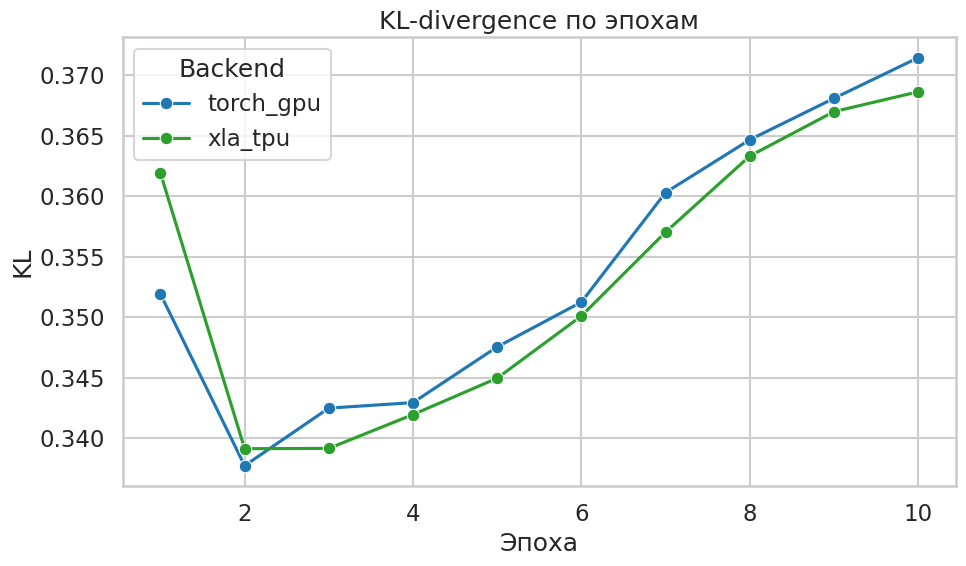

In [18]:
# @title Загрузка history (torch_gpu / xla_tpu) и графики (seaborn)

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

sns.set_theme(style="whitegrid", context="talk")

# --- 1. Загружаем 2 JSON-файла через диалог ---

print("Выберите 2 JSON-файла с history (torch_gpu и xla_tpu).")
uploaded = files.upload()  # словарь: {filename: bytes}

records = []

def infer_backend_from_name(name: str) -> str:
    n = name.lower()
    if "torch" in n and "gpu" in n:
        return "torch_gpu"
    if "xla" in n and "tpu" in n:
        return "xla_tpu"
    # fallback: если что-то странное — просто имя файла
    return name

for fname, content in uploaded.items():
    backend = infer_backend_from_name(fname)
    data = json.loads(content.decode("utf-8"))
    for entry in data:          # entry: {"epoch", "time_sec", "loss", "recon", "kl", ...}
        e = dict(entry)
        e["backend"] = backend
        records.append(e)

df = pd.DataFrame(records)
df = df.sort_values(["backend", "epoch"]).reset_index(drop=True)

display(df.head())

# --- 2. Строим графики ---

palette = {
    "torch_gpu": "#1f77b4",
    "xla_tpu": "#2ca02c",
}

# Время на эпоху
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x="epoch",
    y="time_sec",
    hue="backend",
    marker="o",
    palette=palette,
)
plt.title("Время обучения на эпоху")
plt.xlabel("Эпоха")
plt.ylabel("Время, сек")
plt.legend(title="Backend")
plt.tight_layout()
plt.show()

# Total loss
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x="epoch",
    y="loss",
    hue="backend",
    marker="o",
    palette=palette,
)
plt.title("Total loss по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend(title="Backend")
plt.tight_layout()
plt.show()

# Reconstruction loss
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x="epoch",
    y="recon",
    hue="backend",
    marker="o",
    palette=palette,
)
plt.title("Reconstruction loss по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Recon loss")
plt.legend(title="Backend")
plt.tight_layout()
plt.show()

# KL-divergence
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x="epoch",
    y="kl",
    hue="backend",
    marker="o",
    palette=palette,
)
plt.title("KL-divergence по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("KL")
plt.legend(title="Backend")
plt.tight_layout()
plt.show()
